In [1]:
from transformers import XLMRobertaTokenizer, XLMRobertaForMaskedLM
model = XLMRobertaForMaskedLM.from_pretrained('xlm-roberta-base')

In [2]:
def encode(s):
    return tokenizer([s], return_tensors='pt', padding=True, truncation=True)['input_ids'][0]

In [3]:
from pathlib import Path
import sys
LEXSUBGEN_ROOT = "/home/dmitrii/junk/copy/multilang-lsg"
if LEXSUBGEN_ROOT not in sys.path:
    sys.path.insert(0, LEXSUBGEN_ROOT)


import logging
import os
import json
import random
import torch
import numpy as np
import pickle
import hashlib
from string import punctuation
from pathlib import Path
from typing import List, Tuple, Dict, NoReturn
from overrides import overrides
from transformers import XLMRobertaTokenizer, XLMRobertaForMaskedLM
from evaluation.lexsubeval.dataset import Dataset


def max_aggregating(t1, t2):
    return float((t1.max(dim=0).values * t2.max(dim=0).values).sum())

class ClassifierApplier:
    def __init__(
        self,
        model,
        vocab,
        translator,
        aggreagating_function,
    ):
        self.model = model
        self.vocab = vocab
        self.translator = translator
        self.aggreagating_function = aggreagating_function

    def get_probs(self, start_of_sent, target, end_of_sent):
        with torch.no_grad():
            if target not in self.vocab:
                for _ in range(4):
                    try:
                        self.vocab[target] = [tr.strip() for tr in self.translator.translate(target, return_all=True) if len(tr.strip().split()) == 1]
                        break
                    except:
                        pass
            start_tokens = encode(start_of_sent)[:-1]
            start_tokens_len = len(start_tokens)
            target_word_tokens = encode(target)[1:-1]
            target_word_len = len(target_word_tokens)
            end_tokens = encode(end_of_sent)[1:]
            end_tokens_len = len(end_tokens)
            start_translation = end_tokens_len + target_word_len + start_tokens_len
            result = {}
            target_tokens_idx = list(range(start_tokens_len, start_tokens_len + target_word_len))
            model_input = torch.cat((start_tokens, target_word_tokens, end_tokens)).reshape(1, -1)
            x = model.roberta.embeddings.forward(model_input.to('cuda'))
            for layer in model.roberta.encoder.layer:
                x = layer.forward(x)[0]
            x = x.to('cpu')
            target_emb = x[0, target_tokens_idx].max(dim=0).values
            for translation in self.vocab[target]:
                translation_tokens = encode(translation)[1:-1]
                if len(translation_tokens) > 0:
                    from sklearn.feature_extraction.text import strip_accents_unicode
                    translation = strip_accents_unicode(translation.strip())
                    translation_tokens = encode(translation)[1:-1]
                    translation_tokens_len = len(translation_tokens)
                    translation_tokens_idx = list(range(start_tokens_len, start_tokens_len + translation_tokens_len))
                    model_input = torch.cat((start_tokens, translation_tokens, end_tokens)).reshape(1, -1)
                    x = model.roberta.embeddings.forward(model_input.to('cuda'))
                    for layer in model.roberta.encoder.layer:
                        x = layer.forward(x)[0]
                    x = x.to('cpu')
                    translation_emb = x[0, translation_tokens_idx].max(dim=0).values
                    result[translation] = float((target_emb * translation_emb).sum())
        return result
        


def xlmr_baseline(args):
    dataset = Dataset.from_name(args.dataset)
    lang, inst_idxs, target_lemmas, pos_list, contexts = dataset.read_dataset()
    config = json.loads(args.method_args)
    processor = ClassifierApplier(model, dict(), translator, max_aggregating)
    res = dict()
    outs = []
    counter = 0
    for key, cont, t_l in zip(inst_idxs, contexts, target_lemmas):
        counter += 1
        print(counter)
        if key in dataset.gold_substitutes:
            r = dataset.gold_substitutes[key] 
            gold_s = str(r)
        else:
            gold_s = "None"

        word = cont[1].strip().lower()

        l = len([t for t in cont[0].strip().split() if len(t) > 0])
        preds1 = processor.get_probs(cont[0].strip(), cont[1].strip(), cont[2].strip())
        preds2 = []
        preds = dict()
        for k in set(list(preds2) + list(preds1)):
            preds[k] = 0
            if k in preds1:
                preds[k] += preds1[k]
            if k in preds2:
                preds[k] += preds2[k]

        preds_top_5 = [k for k, v in sorted(preds.items(), key=lambda x: -x[1])][:30]
        top_5 = []
        print(key, " ".join(list(cont)), gold_s, preds_top_5)
        res[key] = preds_top_5
    return res, outs


from typing import List, Dict
from pathlib import Path
import argparse
import logging
from datetime import datetime
import pandas as pd
from collections import OrderedDict, defaultdict
from itertools import chain
from pprint import pprint

from evaluation.lexsubeval.evaluate import evaluate_lexsub

logger = logging.getLogger()

WORKDIR = Path(".").resolve()

def get_debug_dir_name():
    return datetime.now().isoformat().split('.')[0].replace(':', '_').replace('-', '_')

def get_substitutes_by_method_name(args) -> Dict[str, List[str]]:
    logger.info(f"Start generating substitutes using {args.method_name}")
    if args.method_name == "vocab-baseline":
        substitutes = xlmr_baseline(args) #vocab_baseline(args)
    else:
        raise ValueError("Unknown method name")
    logger.info(f"Done generating substitutes using {args.method_name}")
    return substitutes

def solve(args):
    debug_dir = WORKDIR / args.debug_dir_name / get_debug_dir_name()
    if not debug_dir.exists():
        debug_dir.mkdir(parents=True, exist_ok=False)

    substitutes, outs = get_substitutes_by_method_name(args)

    logger.info(f"Start evaluating {args.method_name}")

    scores = evaluate_lexsub(args.dataset, substitutes)

    logger.info(f"Done evaluating {args.method_name}")

    main_info = [
        ("method", args.method_name),
    ]

    additional_info = [
        ("method-args", args.method_args),
        ("dataset", args.dataset)
    ]

    results = OrderedDict((k, [v]) for k, v in chain(main_info, scores.items(), additional_info))

    df = pd.DataFrame.from_dict(results)

    results_path = debug_dir / "results.csv"
    df.to_csv(results_path)
    logger.info(f"Results were saved to: '{results_path}'")

    #print(df)
    #pprint(results)
    return results, outs

class Args:
    def __init__(self):
        self.dataset = "semeval2010task2/trial"
        self.method_name = "vocab-baseline"
        self.method_args = '{"translate_mode": "w2w"}'
        self.debug_dir_name = 'debug'

In [4]:
#model = model.to('cuda')

In [5]:
#result, outs = solve(Args())

In [6]:
#result, outs

In [7]:
import spacy

In [8]:
import spacy_spanish_lemmatizer

In [9]:
help(spacy_spanish_lemmatizer)

Help on package spacy_spanish_lemmatizer:

NAME
    spacy_spanish_lemmatizer - # flake8: noqa

PACKAGE CONTENTS
    __main__
    config
    lemmatizer
    main
    parser (package)

FILE
    /home/dmitrii/anaconda3/lib/python3.8/site-packages/spacy_spanish_lemmatizer/__init__.py




In [10]:
nlp = spacy.load("es_core_news_sm")

In [11]:
nlp = spacy.load("es_core_news_sm")
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

In [12]:
nlp("brillanter")

brillanter

In [13]:
#help(token)

In [14]:
#pos("monitorea")[0] in {"ADJ", "PROPN", "NOUN", "VERB"}

In [15]:
for token in nlp(
    """Con estos fines, la Dirección de Gestión y Control Financiero monitorea
       la posición de capital del Banco y utiliza los mecanismos para hacer un
       eficiente manejo del capital.  gravemente"""
):
    print(token.text, token.lemma_, token.norm_, token.pos_)

Con con con ADP
estos este estos DET
fines fin fines NOUN
, , , PUNCT
la el la DET
Dirección Dirección dirección PROPN
de de de ADP
Gestión Gestión gestión PROPN
y y y CCONJ
Control Control control PROPN
Financiero Financiero financiero PROPN
monitorea monitoreo monitorea ADJ

        
        
        SPACE
la el la DET
posición posición posición NOUN
de de de ADP
capital capital capital NOUN
del del del ADP
Banco Banco banco PROPN
y y y CCONJ
utiliza utilizar utiliza VERB
los el los DET
mecanismos mecanismo mecanismos NOUN
para para para ADP
hacer hacer hacer VERB
un uno un DET

        
        
        SPACE
eficiente eficiente eficiente ADJ
manejo manejo manejo NOUN
del del del ADP
capital capital capital NOUN
. . . PUNCT
      SPACE
gravemente gravemente gravemente ADV


In [16]:
import torch

In [17]:
from transformers import XLMRobertaTokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
text_batch = ["I love Pixar.", "I don't care for Pixar."]
encoding = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [18]:
text_batch = ["I love Pixar.", "I don't care for Pixar."]
tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)

{'input_ids': tensor([[     0,     87,   5161, 159939,    147,      5,      2,      1,      1,
              1,      1],
        [     0,     87,   2301,     25,     18,    517,    100, 159939,    147,
              5,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [19]:
#model.embeddings.word_embeddings((input_ids))

In [20]:
#model.lm_head(model.roberta.encoder.forward(model.roberta.embeddings.word_embeddings((input_ids)))[0]).shape

In [21]:
model

XLMRobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [22]:
#model.encoder.forward()

In [23]:
#model.roberta.embeddings.word_embeddings(torch.tensor([0]))

In [24]:
#list(model)

In [25]:
text_batch = ["I love Pixar.", "<mask>, I don't care for Pixar."]
encoding = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [26]:
encoding['input_ids'][1]

tensor([     0, 250001,      6,      4,     87,   2301,     25,     18,    517,
           100, 159939,    147,      5,      2])

In [27]:
#model = model.to('cpu')

In [28]:
t = tokenizer("If your money is tight (Spanish: <mask>) do n't cut corners .")
#out = model(torch.tensor(t['input_ids']).reshape(1, -1))[0]

In [29]:
#torch.tensor(t['input_ids']).reshape(1, -1).argmax()

In [30]:
#out[0, 10].argmax()

In [31]:
#tokenizer.decode(torch.tensor([0, 44130, 2]))

In [32]:
#out[0]

In [33]:
#[i.argmax() for i in out[0]]

In [34]:
#tokenizer.decode(torch.tensor([i.argmax() for i in out[0]]))

In [35]:
#t['input_ids']

In [36]:
tokenizer.decode(encoding['input_ids'][1])

"<s><mask>, I don't care for Pixar.</s>"

In [37]:
#labels

In [38]:
#model

In [39]:
#tokenizer.decode(torch.tensor([i.argmax() for i in outputs[0][1]]))

In [40]:
#outputs[0][1]

In [41]:
#tokenizer.decode(torch.tensor([i.argmax() for i in outputs[0]]))

In [42]:
#outputs[0]

In [43]:
#optimizer = optimizer.to('cuda')

In [44]:
from datasets import load_dataset

In [45]:
dataset = load_dataset("tatoeba", lang1="en", lang2="es")

Using custom data configuration en-es-lang1=en,lang2=es
Reusing dataset tatoeba (/home/dmitrii/.cache/huggingface/datasets/tatoeba/en-es-lang1=en,lang2=es/0.0.0/54423b66d13968ea583b6ac5828448a54b1a69944cabd3368ccd364fdb4f3216)


  0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
from functools import lru_cache
import nltk
@lru_cache(maxsize=100000)
def tokenize(word):
    return nltk.word_tokenize(word.lower())


In [47]:
from collections import defaultdict
cntr = defaultdict(int)
word_counter = defaultdict(int)
for r in dataset['train']:
    #if len(r['translation']['en'].split()) != len(r['translation']['es'].split()):
    cntr[len(tokenize(r['translation']['en']))] += 1
    #break
    for w in tokenize(r['translation']['en']):
        if w.isalpha():
            word_counter[w] += 1


In [48]:
#sorted(word_counter, key=lambda x: -word_counter[x])[:100]

In [49]:
len(cntr)

105

In [50]:
sorted(cntr.items(), key=lambda x: -x[1])[:10]

[(7, 33014),
 (6, 32324),
 (8, 28513),
 (5, 24987),
 (9, 21643),
 (10, 15248),
 (4, 11882),
 (11, 10446),
 (12, 7248),
 (13, 5027)]

In [51]:
len(word_counter)

23409

In [52]:
sorted(word_counter.items(), key=lambda x: -x[1])[:10]

[('the', 61116),
 ('i', 57750),
 ('to', 46101),
 ('you', 40668),
 ('a', 35417),
 ('is', 31707),
 ('tom', 23922),
 ('he', 19905),
 ('do', 19380),
 ('in', 19043)]

In [53]:
word_counter["I"]

0

In [54]:
len(dataset['train'])

207517

In [55]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 207517
    })
})

In [56]:
from py_babelnet.calls import BabelnetAPI

#api = BabelnetAPI()

In [57]:
#senses = api.get_senses(lemma = "agua", searchLang = "ES")

In [58]:
#!pip install deep_translator

In [59]:
import enchant
d = enchant.Dict("en_US")
d.check("Hello")

True

In [60]:
d.check("wo")

False

In [61]:
words = [k for k in list(word_counter.keys()) if d.check(k)]

In [62]:
[words[i:i+100] for i in range(0, len(words), 100)]

[['let',
  'try',
  'something',
  'i',
  'have',
  'to',
  'go',
  'sleep',
  'today',
  'is',
  'and',
  'it',
  'birthday',
  'now',
  'the',
  'password',
  'will',
  'be',
  'back',
  'soon',
  'at',
  'a',
  'loss',
  'for',
  'words',
  'this',
  'never',
  'going',
  'end',
  'just',
  'do',
  'know',
  'what',
  'say',
  'that',
  'was',
  'an',
  'evil',
  'bunny',
  'in',
  'mountains',
  'recent',
  'picture',
  'if',
  'time',
  'education',
  'world',
  'disappoints',
  'me',
  'you',
  'better',
  'shape',
  'than',
  'am',
  'are',
  'my',
  'way',
  'cost',
  'make',
  'day',
  'may',
  'give',
  'up',
  'nap',
  'instead',
  'because',
  'want',
  'alone',
  'happen',
  'sometimes',
  'he',
  'can',
  'strange',
  'guy',
  'best',
  'not',
  'disturb',
  'your',
  'studying',
  'only',
  'wonder',
  'same',
  'everyone',
  'else',
  'suppose',
  'different',
  'when',
  'think',
  'about',
  'over',
  'long',
  'term',
  'miss',
  'call',
  'them',
  'tomorrow',
  'co

In [63]:
from deep_translator import PonsTranslator, LingueeTranslator, YandexTranslator
translator = PonsTranslator(source='en', target='es')  # output -> Weiter so, du bist großartig

In [64]:
#translator.translate("can", return_all=True,)

In [65]:
#translator.translate_words(["can"], return_all=True,)

In [66]:
if 0:
    word_translations = dict()
    import time
    start_time = time.time()
    for idx, words_batch in enumerate([words[i:i+100] for i in range(0, len(words), 100)]):
        try:
            tr = translator.translate_words(words_batch, return_all=True,)
            wb = words_batch
        except Exception as ex:
            tr = []
            wb = []
            for word in words_batch:
                try:
                    tr.append(translator.translate(word, return_all=True,))
                    wb.append(word)
                except Exception as ex:
                    print(ex)

        for w, t in zip(wb, tr):
            word_translations[w] = list(set([i.strip() for i in t if len(i.strip().split()) == 1]))
        print(idx, time.time() - start_time)


    import pickle
    with open("vocab", "wb") as f:
        pickle.dump(word_translations, f)

In [67]:
word_translations = ()
import pickle
with open("vocab", "rb") as f:
    word_translations = pickle.load(f)

In [68]:
word_translations['test']

['autocomprobación',
 'comprobar',
 'prueba',
 'test',
 'analizar',
 'autocomprobarse',
 'tocar',
 'cutirreacción',
 'examen',
 'examinar',
 'autotest',
 'experimental',
 'probar',
 'evaluar',
 'probeta']

In [69]:
import word2word

In [70]:
from deep_translator import PonsTranslator

def get_translations_pons(words, src_lang: str = "en", dst_lang: str = "es", remove_multi_word=True):
    en2es = PonsTranslator(src_lang, dst_lang)
    NOT_TRANSLATED, TRANSLATION_QUERIES = 0, 0
    unique_words = set(words)
    TRANSLATION_QUERIES += len(unique_words)
    lemma2translations = {}
    for word in unique_words:
        try:
            translations = en2es.translate(word, return_all=True)
        except KeyError:
            translations = []
            NOT_TRANSLATED += 1
        if remove_multi_word:
            translations = list(set([
                translation.strip() for translation in translations if len(translation.strip().split()) == 1]))
        lemma2translations[word] = translations
    return lemma2translations, TRANSLATION_QUERIES, NOT_TRANSLATED

In [71]:
translator.translate('cat', return_all=True)

['gato gata ',
 '¿te comieron la lengua los ratones ',
 '¿te ha comido la lengua el gato ',
 'se cree el súmmum ',
 '¡hombre mira quién viene por aquí ',
 '¡parece que vinieras de la guerra ',
 'no tener la más mínima posibilidad ',
 'no cabe ni un alfiler ',
 'estar sobre ascuas ',
 'andar como el perro el gato ',
 'esos dos se llevan están siempre como el perro el gato ',
 'sonreír de oreja oreja ',
 'descubrir el pastel ',
 'levantar la liebre ',
 'levantar la perdiz ',
 'jugar al gato al ratón con ',
 'llover cántaros mares ',
 'ver por dónde van los tiros ',
 'levantar un revuelo ',
 'cuando el gato duerme bailan los ratones ',
 'los ojos son para mirar ',
 'con mirar no se desgasta ',
 'felino ',
 'los felinos mayores ',
 'arpía ',
 'tipo ',
 'oruga ',
 'azotador ',
 'cuncuna ',
 'oruga ',
 'oruga ',
 'miedoso miedosa ',
 'miedica ',
 'potentado potentada ',
 'sueldo de potentados ',
 'pingües beneficios ',
 'pingües ganancias ',
 'jugar hacer cunitas ',
 'ladrón ladrona ',
 'ces

In [72]:
#get_translations_pons(words[:100])

In [73]:
import pickle

In [74]:
from deep_translator import MyMemoryTranslator

In [75]:
translator_mm = MyMemoryTranslator(source='en', target='es')

In [76]:
translator_mm.translate("bank", return_all=True)

'banco'

In [77]:
import word2word

In [78]:
import spacy

In [79]:
snlp = spacy.load('es_core_news_sm')
#snlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
#token = token.lemma_
from functools import lru_cache
@lru_cache(maxsize=100000)
def lemmatize(s):
    res = []
    for token in snlp(s):
        #p = morph.parse(s)[0]
        res.append(token.lemma_)
    return res

@lru_cache(maxsize=100000)
def pos(s):
    res = []
    for token in snlp(s):
        #p = morph.parse(s)[0]
        res.append(token.pos_)
    return res

from textblob import TextBlob, Word
# Lemmatize a word
word = 'are'
w = Word(word)

@lru_cache(maxsize=100000)
def lematize_english(word):
    return Word(word).lemmatize()

In [80]:
s = set({"ada", "cac"})
s.add("dada")

In [81]:
s

{'ada', 'cac', 'dada'}

In [82]:
from word_forms.word_forms import get_word_forms

In [83]:
get_word_forms("be")

{'n': {'being', 'beings'},
 'a': set(),
 'v': {'am',
  'am not',
  'are',
  "aren't",
  'be',
  'been',
  'being',
  'is',
  "isn't",
  'was',
  "wasn't",
  'were',
  "weren't"},
 'r': set()}

In [84]:
import json
import subprocess
import re

In [85]:
def get_translations_w2w(words, src_lang: str = "en", dst_lang: str = "es"):
    en2es = word2word.Word2word(src_lang, dst_lang)
    NOT_TRANSLATED, TRANSLATION_QUERIES = 0, 0
    unique_words = set(words)
    unique_words_lemmas = []
    for w in unique_words:
        l = lematize_english(w)
        if l not in unique_words:
            unique_words_lemmas.append(l)

    unique_words = set(list(unique_words) + unique_words_lemmas)
    TRANSLATION_QUERIES += len(unique_words)
    lemma2translations = {}
    for idx, word in enumerate(unique_words):
        if word not in lemma2translations:
            translations2 = []
            word_forms = get_word_forms(word)
            for part_of_speech in word_forms:
                for word_form in list(word_forms[part_of_speech]) + [word]:
                    try:
                        if word_form not in lemma2translations:
                            translations = en2es(word_form)
                            for w in translations:
                                #if pos(w)[0] in {"ADJ", "ADV", "NOUN", "VERB", "PROPN", "RB", "RBR", "RBS"}: 
                                translations2.append(w)
                        else:
                            translations2 = translations2 + lemma2translations[word_form]
                    except KeyError:
                        NOT_TRANSLATED += 1
            for part_of_speech in word_forms:
                for word_form in word_forms[part_of_speech]:
                    lemma2translations[word_form] = list(set(translations2))
        #if idx % 500 == 0:
        #    print(idx, len(unique_words), NOT_TRANSLATED)
    return lemma2translations, TRANSLATION_QUERIES, NOT_TRANSLATED

In [86]:
#word_translations, _, _ = get_translations_w2w(word_counter.keys())

In [87]:
#word_translations = tr

In [88]:
from tqdm.auto import tqdm

def translate(words,):
    res = {}
    progress_bar = tqdm(range(len(words)))
    for word in words:
        try:
            print(word)
            res[word] = translator.translate(word, return_all=True)
        except Exception as ex:
            print(str(ex))
            if ex is KeyboardInterrupt:
                raise ex
        progress_bar.update(1)
    return res

In [89]:
#word_translations = translate(word_counter.keys())

In [90]:
len(word_translations)

19384

In [91]:
import spacy

In [92]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
p = morph.parse('стали')[0]
p.normal_form

'стать'

In [93]:
#spacy.download("es_core_news_sm")

In [94]:
sorted(word_translations.items(), key=lambda x: -len(x[1]))[:10]

[('broken',
  ['destartalado',
   'fuga',
   'parar',
   'incluso',
   'interrumpido',
   'descomponer',
   'persona',
   'formular',
   'revelar',
   'quebrado',
   'faltar',
   'voz',
   'ruinoso',
   'corte',
   'espíritu',
   'descanso',
   'entreacto',
   'quebrarse',
   'destrozar',
   'interrupción',
   'intermedio',
   'rescatar',
   'cambiar',
   'igualar',
   'fin',
   'descorazonarse',
   'desarmar',
   'animarse',
   'par',
   'deshecho',
   'gratuito',
   'todavía',
   'recreo',
   'deshacer',
   'accidentado',
   'derecho',
   'ley',
   'carnerear',
   'desenganchar',
   'desmontar',
   'roturar',
   'disponer',
   'exacto',
   'recortado',
   'atrevido',
   'averiado',
   'liberar',
   'desmoronarse',
   'expresar',
   'ánimos',
   'romperse',
   'garabato',
   'descomponerse',
   'contraataque',
   'generoso',
   'soltarse',
   'acompasado',
   'descompuesto',
   'recomendar',
   'desocupado',
   'separarse',
   'corazones',
   'suelto',
   'despuntar',
   'partir',
   

In [95]:
#word_translations["we"]

In [96]:
word_translations['cat']

['TAC',
 'gato',
 'pasarela',
 'tipo',
 'arpía',
 'cuncuna',
 'miedica',
 'felino',
 'azotador',
 'TAO',
 'oruga']

In [97]:
#len(dataset['train'])

In [98]:
#len(word_translations)

In [99]:
cntr = 0
for r in dataset['train']:
    src = tokenize(r['translation']['en'])
    break
    for t in src:
        if t in word_translations:
            cntr += 1
cntr

0

In [100]:
encode("I am")[1:-1]

tensor([ 87, 444])

In [101]:
encode("")[1:-1]

tensor([], dtype=torch.int64)

In [102]:
MASK_ID = encode("<mask>")[1]
MASK_ID

tensor(250001)

In [103]:
len(dataset['train'])

207517

In [104]:
from collections import defaultdict

In [105]:
train_len = int(len(dataset['train']) * 0.9)

In [106]:
train_len

186765

In [107]:
dataset['train']

Dataset({
    features: ['id', 'translation'],
    num_rows: 207517
})

In [108]:
data = [r for r in dataset['train']]

In [109]:
import random
random.shuffle(data)

In [110]:
data[:10]

[{'id': '57395',
  'translation': {'en': 'She saw a tall man yesterday.',
   'es': 'Ayer vio a un hombre alto.'}},
 {'id': '103349',
  'translation': {'en': 'Tom had a hunch that Mary was lying.',
   'es': 'Tom tenía el presentimiento de que Mary estaba mintiendo.'}},
 {'id': '162813',
  'translation': {'en': 'Tom never saw Mary.', 'es': 'Tom nunca vio a Mary.'}},
 {'id': '24540',
  'translation': {'en': 'The curtains make this room beautiful.',
   'es': 'Las cortinas hacen que esta habitación sea hermosa.'}},
 {'id': '112856',
  'translation': {'en': 'I liked walking alone on the deserted beach.',
   'es': 'Me gustaba caminar solo por la playa desierta.'}},
 {'id': '206887',
  'translation': {'en': 'Rick was twenty two years old and fresh out of the military when I first photographed him. He was already well known in San Francisco where he lived and well liked. These photographs in particular were taken before he would film his first video.',
   'es': 'Rick tenía veintidós años y reci

In [111]:
PAD_ID = encode("<pad>")[1]
PAD_ID

tensor(1)

In [112]:
from functools import lru_cache
import nltk

@lru_cache(maxsize=100000)
def tokenize(word):
    return nltk.word_tokenize(word.lower())

@lru_cache(maxsize=100000)
def tokenize_s_case(word):
    return nltk.word_tokenize(word)

@lru_cache(maxsize=100000)
def get_normal_sent(sent):
    return " ".join(tokenize_s_case(sent))

In [113]:
word_translations

{'let': ['pegar',
  'debilitarse',
  'correr',
  'parar',
  'agrandar',
  'soltar',
  'ensanchar',
  'vámonos',
  'gota',
  'omitir',
  'descenso',
  'alquilarse',
  'lanzar',
  'descender',
  'revelar',
  'perder',
  'desplomarse',
  'empotrar',
  'renunciar',
  'disminuir',
  'reducir',
  'digamos',
  '¡vámonos',
  'deber',
  '¡oremos',
  'cairel',
  '¡ábreme',
  'retirar',
  'tener',
  'alargar',
  'bajar',
  'desaparecer',
  'caer',
  'oremos',
  'escapatoria',
  'ser',
  'anclar',
  'suavizarse',
  'tumbar',
  'alquilar',
  'red',
  'escape',
  'abandonar',
  'colirio',
  'perdonar',
  'derribar',
  'vamos',
  'parir',
  'gotas',
  'culminar',
  'amainar',
  'alargarse',
  'baja',
  'disparar',
  'estar',
  'dejar',
  'escapada',
  'aflojar',
  'terminar',
  'veamos',
  'eximir',
  'colocar',
  'escotillón',
  'salto',
  'mandar',
  'desinflar',
  'alquiler',
  'buzón',
  'let',
  'desvanecerse',
  'decepcionar',
  'caída',
  'tirar',
  'lanzamiento',
  'lágrima'],
 'try': ['triqu

In [114]:
import random

In [115]:
def negative_samples_generator(word_translations, return_num_tranlations=20):
    translations = list(set([translation for word, translations in word_translations.items() for translation in translations]))
    while True:
        random.shuffle(translations)
        yield translations[:return_num_tranlations]

In [116]:
#g = negative_samples_generator(word_translations)

In [117]:
#next(g)

In [118]:
def get_data_by_num_tokens(data):
    prepared_data = list()
    import time, random
    counter = 0
    start_time = time.time()
    #most_popular = sorted(word_counter, key=lambda x: -word_counter[x])[:100]
    translation_generator = negative_samples_generator(word_translations)
    data_len = len(data)
    for row_num, r in enumerate(data):
        src_dont_splitted = r['translation']['en']
        src = tokenize_s_case(r['translation']['en'])
        dst = tokenize_s_case(r['translation']['es'])
        if row_num % 100 == 0:
            print(row_num, data_len, time.time() - start_time)
        for idx, w in enumerate(src):
            if w in word_translations and len(word_translations[w]) and src_dont_splitted.count(w) == 1:
                start = " ".join(src[:idx])
                start_tokens = encode(start)[:-1]
                end = " ".join(src[idx+1:])
                end_tokens = encode(end)[1:]
                #if random.random() < 0.5:
                target_word_tokens = encode(w)[1:-1]
                #else:
                    #target_word_tokens = encode("<mask>")[1:-1]
                    #assert len(target_word_tokens) == 1
                data = dict()
                data["target"] = torch.cat((start_tokens, target_word_tokens, end_tokens))
                data["target_ids"] = list(range(len(start_tokens), len(start_tokens) + len(target_word_tokens)))
                data["translations"] = []
                data["translations_ids"] = []
                for word in set(word_translations[w]):
                    if word.strip() in dst:
                        data["real_translation"] = word
                if "real_translation" not in data:
                    continue
                for tranlation in set(word_translations[w]):
                    tranlation_tokens = encode(tranlation)[1:-1]
                    data["translations"].append(torch.cat((start_tokens, tranlation_tokens, end_tokens)))
                    data["translations_ids"].append(list(range(len(start_tokens), len(start_tokens) + len(tranlation_tokens))))
                data["neg_translations"] = []
                data["neg_translations_ids"] = []
                for tranlation in next(translation_generator):
                    tranlation_tokens = encode(tranlation)[1:-1]
                    data["neg_translations"].append(torch.cat((start_tokens, tranlation_tokens, end_tokens)))
                    data["neg_translations_ids"].append(list(range(len(start_tokens), len(start_tokens) + len(tranlation_tokens))))
                prepared_data.append(data)    
                #x = encode(src_dont_splitted.replace(w, "{} (Spanish: {})".format(w, "<mask>" * 3)))
            
    print("Finished prepare data Total data {} Total time {}".format(counter, time.time() - start_time))
    return prepared_data

In [119]:
import pickle

import time 
st = time.time()
with open("translations_data_train", "rb") as f:
    prepared_data_by_num_target_tokens = pickle.load(f) #get_data_by_num_tokens(data[:train_len])
print(time.time() - st)

532.9261360168457


In [120]:
import time 
st = time.time()
with open("translations_data_valid", "rb") as f:
    prepared_data_by_num_target_tokens_valid = pickle.load(f) #get_data_by_num_tokens(data[:train_len])
print(time.time() - st)

2.3425424098968506


In [121]:
len(word_translations)

19384

In [122]:
s = 0
for word in word_translations:
    s += len(word_translations[word])
s

143238

In [123]:
s / len(word_translations)

7.3894964919521255

In [124]:
s = []
for word in word_translations:
    s = s + word_translations[word]

In [125]:
len(set(s))

24202

In [126]:
#import pickle
#with open("vocab", "wb") as f:
#    pickle.dump(word_translations, f)

In [127]:
s = []

In [128]:
import pickle

In [129]:
train_len = len(data) - 1000
train_len

206517

In [130]:
#prepared_data_by_num_target_tokens = get_data_by_num_tokens(data[:train_len])
#with open("translations_data_train", "wb") as f:
#    pickle.dump(prepared_data_by_num_target_tokens, f)

In [131]:
#prepared_data_by_num_target_tokens_valid = get_data_by_num_tokens(data[train_len:])
#with open("translations_data_valid", "wb") as f:
#    pickle.dump(prepared_data_by_num_target_tokens_valid, f)#

In [132]:
sentense_example = 'During the siege , George Robertson had appointed Shuja-ul-Mulk , who was a bright (Spanish: <mask><mask><mask>) boy only 12 years old and the youngest surviving son of Aman-ul-Mulk , as the ruler of Chitral.'

In [133]:

import random

In [134]:
[random.randint(0, 1) for _ in range(10)]

[0, 0, 1, 1, 1, 0, 0, 1, 1, 0]

In [135]:
class BatchGenerator:
    def __init__(self, data, batch_max_num_tokens=1000):
        prepared_data = []
        for row in data:
            prepared_row = []
            prepared_row.append(row["target"])
            prepared_row.append(row["target_ids"])
            data_by_num_tokens = defaultdict(list)
            for translation, ids in zip(row["translations"], row["translations_ids"]):
                data_by_num_tokens[len(translation)].append((translation, ids, 1))
            for translation, ids in zip(row["neg_translations"], row["neg_translations_ids"]):
                data_by_num_tokens[len(translation)].append((translation, ids, 0))
            for t in data_by_num_tokens:
                random.shuffle(data_by_num_tokens[t])
            def prepare_batch(batch):
                X = torch.LongTensor([list(i[0]) for i in batch])
                ids = torch.LongTensor(batch[0][1])
                targets = torch.LongTensor([i[2] for i in batch])
                return X, ids, targets
        
            batches = []
            for row_len in data_by_num_tokens:
                for i in range(0, len(data_by_num_tokens[row_len]), int(batch_max_num_tokens / row_len)):
                    batches.append(prepare_batch(data_by_num_tokens[row_len][i : i + row_len]))
                                                                
            
            prepared_row.append(batches)
            prepared_data.append(prepared_row)
        self.data = prepared_data

    def get_batch_generator(self):
        random.shuffle(self.data)
        def batch_generator(batches):
            for batch in batches:
                yield batch
        for target, target_ids, batches in self.data:
            yield target, target_ids, batch_generator(batches)

In [136]:
random.shuffle([1,2,3])

In [137]:
#sorted([(k, len(v)) for k, v in prepared_data_by_num_target_tokens.items()])

In [138]:
#prepared_data_by_num_target_tokens[(1, 276)]

In [139]:
gen = BatchGenerator(prepared_data_by_num_target_tokens)

In [140]:
len(gen.data)

482382

In [141]:
gen_valid = BatchGenerator(prepared_data_by_num_target_tokens_valid[:1000])

In [142]:
#model = model.to('cuda')

In [143]:
def get_params(model, num_layers=1):
    for i in range(12 - num_layers, 12):
        yield model.roberta.encoder.layer[i].parameters()


In [144]:
for param in model.parameters():
    param.requires_grad = False

In [145]:
for layer in get_params(model):
    for param in layer:
        param.requires_grad = True

In [146]:
import gc

gc.collect()

75

In [147]:
import gc

gc.collect()

15

In [148]:
import torch.nn as nn

In [149]:
model

XLMRobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [150]:
class Classifier(nn.Module):
    def __init__(self, xlmr):
        super().__init__()
        self.xlmr = xlmr

    def get_embs(self, input_tokens, target_ids):
        inp = input_tokens.to('cuda')
        x = self.xlmr.roberta.embeddings.forward(inp)
        for layer in self.xlmr.roberta.encoder.layer:
            x = layer.forward(x)[0]
        return x[:, target_ids].max(dim=1).values

    def parameters(self):
        return self.xlmr.parameters()
        
    def get_target_embs(self, target_sent, target_ids):
        return self.get_embs(target_sent.reshape(1, -1), target_ids)

In [151]:
cl = Classifier(model)
from torch.optim import AdamW
NUM_EPOCH = 50
num_warmup_steps = 2000
NUM_BATCHES_PER_EPOCH = 1000
num_training_steps = NUM_BATCHES_PER_EPOCH * NUM_EPOCH
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(cl.parameters(), lr=1e-7)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

In [152]:
torch.Tensor([[1], [2], [3]]).mean(dim=1)

tensor([1., 2., 3.])

In [153]:
#torch.cat((torch.Tensor().to('cuda'), (t1 * t2).sum(axis=-1), (t1 * t2).sum(axis=-1)))


In [154]:
import torch.nn.functional as F

In [155]:
F.softmax(torch.Tensor([1, -1]))

<ipython-input-155-4214d25c347a>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.Tensor([1, -1]))


tensor([0.8808, 0.1192])

In [156]:
delta = 0.1
def loss_function_max(values, mask):
    return F.relu(values[mask == 0].max() + delta - values[mask == 1].max()).sum()

In [157]:
one_tensor = torch.Tensor([1]).to('cuda')
def loss_function_max_sigmoid(values, mask):
    return F.binary_cross_entropy(F.sigmoid(values[mask == 1].max() - values[mask == 0].max()).reshape(-1), one_tensor)

In [158]:
loss_function_max_sigmoid(torch.Tensor([1, -1]).to('cuda'), torch.Tensor([1, 0]))

/home/dmitrii/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1269, device='cuda:0')

In [159]:
def loss_function_sum_prob(values, mask):
    if mask.sum() > 0:
        return -torch.log((F.softmax(values)[mask == 1]).sum() + 0.001) - float(1 / mask.sum()) * torch.log((F.softmax(values)[mask == 1]) + float(0.001)).sum()
    else:
        return -torch.log((F.softmax(values)).sum())

In [160]:
#loss_function_sum_prob(torch.Tensor([100, 1]), torch.Tensor([1, 0]))

In [161]:
#loss_function = loss_function_max_sigmoid

In [162]:
a = torch.Tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.])

In [163]:
b = torch.Tensor([357.4563, 355.4532, 357.2860, 355.2354, 357.3218, 357.8637, 356.9639,
        356.8268, 358.6297, 357.6566, 357.3449, 357.7099, 359.0984, 357.4477,
        357.9814, 358.1726, 357.7754, 361.5155, 358.1756, 356.7641, 355.3839,
        358.8397, 356.6861, 357.7323, 356.4861, 213.0071, 357.2876, 356.6857,
        363.4889, 357.3142, 357.3372, 355.4458, 355.7588, 364.9325])

In [164]:
#loss_function = loss_function_max_sigmoid
loss_function = loss_function_sum_prob

from IPython.display import clear_output
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot(iters_train, iters_valid, train, valid, iters_lr, lr, metrics_iter, metrics, outs):
    clear_output()
    print(train, valid)
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))
    ax1, ax4, ax2, ax3 = ax.flatten()
    ax1.plot(list(range(len(train))), train, label='Train')
    ax1.plot(list(range(len(valid))), valid, label='Valid')
    ax1.legend()
    ax1.grid()
    try:
        ax4.plot(list(range(len(train))), np.log(np.array(train)), label='Train log average cross entropy')
        ax4.plot(list(range(len(valid))), np.log(np.array(valid)), label='Valid log average cross entropy')
        ax4.legend()
        ax4.grid()
    except:
        pass
    ax2.plot(iters_lr, lr, label='lr')
    ax2.grid()
    ax2.legend()
    for metric in metrics:
        ax3.plot(metrics_iter, metrics[metric], label=metric)
    ax3.legend()
    ax3.grid()
    plt.show()
    for r in outs:
        print(r)

def train_model():
    import time
    from random import shuffle
    from tqdm.auto import tqdm
    train_loss = []
    valid_loss = []
    iters_train = []
    iters_valid = []
    s_loss = 0
    best_loss = -100000
    last_10 = []
    step = 0
    start_time = time.time()
    metrics = defaultdict(list)
    lr = []
    delta = 0.1
    progress_bar = tqdm(range(len(gen_valid.data)))
    if 0:
        with torch.no_grad():
            model.eval()
            loss_s = 0
            num_s = 0
            for targer_sent, target_ids, batch_gen in list(gen_valid.get_batch_generator()):
                target = cl.get_target_embs(targer_sent, target_ids)
                res = torch.Tensor([]).to('cuda')
                is_translate = torch.Tensor([])
                for X, ids, y in batch_gen:
                    outs = (target * cl.get_embs(X, ids)).sum(axis=-1) #.to('cpu')
                    res = torch.cat((res, outs))
                    is_translate = torch.cat((is_translate, y))
                if is_translate.sum() > 0.5:
                    #print(res, is_translate)
                    loss_s += loss_function(res, is_translate)
                    num_s += 1
            valid_loss.append(float(loss_s) / int(num_s))
            iters_valid.append(step)
            res, outs = solve(Args())
            metrics['se10t2-rec@1'].append(res['se10t2-rec@1'][0])
            metrics['se10t2-mrec@1'].append(res['se10t2-mrec@1'][0])
            metrics['se10t2-rec@10'].append(res['se10t2-rec@10'][0])
            metrics['se10t2-mrec@10'].append(res['se10t2-mprec@10'][0])
            loss = res['se10t2-mprec@10'][0]
            last_10.append(loss)
            model.train() 

    plot(iters_train, iters_valid, train_loss, valid_loss, iters_train, lr, iters_valid, metrics, [])
    model.train()
    for i in range(NUM_EPOCH):
        progress_bar = tqdm(range(NUM_BATCHES_PER_EPOCH))
        s_loss = 0.0
        counter = 0
        torch.cuda.empty_cache()
        for targer_sent, target_ids, batch_gen in list(gen.get_batch_generator())[:NUM_BATCHES_PER_EPOCH]:
            try:
                target = cl.get_target_embs(targer_sent, target_ids)
                res = torch.Tensor([]).to('cuda')
                is_translate = torch.Tensor([])
                for X, ids, y in batch_gen:
                    outs = (target * cl.get_embs(X, ids)).sum(axis=-1) #.to('cpu')
                    res = torch.cat((res, outs))
                    is_translate = torch.cat((is_translate, y))
                try:
                    #loss = loss_function(res[is_translate == 1].max(), res[is_translate == 0].max())
                    loss = loss_function(res, is_translate)
                    loss.backward()
                    #print(loss, res[is_translate == 1], res[is_translate == 0], res, is_translate)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                    optimizer.step()
                    scheduler.step()
                    s_loss += float(loss)
                except Exception as ex:
                    print(str(ex), is_translate)
                    if is_translate.sum() > 1:
                        gc.collect()
                        gc.collect()
            except Exception as ex:
                print(str(ex))
                try: 
                    del target
                    del res
                    del is_translate
                    del outs
                except:
                    pass
                optimizer.zero_grad()
                model.zero_grad()
                gc.collect()
                torch.cuda.empty_cache()
                gc.collect()
                torch.cuda.empty_cache()
            optimizer.zero_grad()
            model.zero_grad()

            progress_bar.update(1)
            #counter += len(y)
            #train_loss.append(float(s_loss))
            iters_train.append(step)
            lr.append(optimizer.state_dict()["param_groups"][0]["lr"])
            step += 1
            #if step % 200 == 0:
            #    plot(iters_train, iters_valid, train_loss, valid_loss, iters_train, lr, iters_valid, metrics, [])
            #    print(i, time.time() - start_time, train_loss[-1], valid_loss[-1], metrics)
            torch.cuda.empty_cache()
        train_loss.append(float(s_loss) / step)
        plot(iters_train, iters_valid, train_loss, valid_loss, iters_train, lr, iters_valid, metrics, [])
        #progress_bar = tqdm(range(len(gen_valid.y)))
        with torch.no_grad():
            model.eval()
            loss_s = 0
            num_s = 0
            progress_bar = tqdm(range(len(gen_valid.data)))
            for targer_sent, target_ids, batch_gen in list(gen_valid.get_batch_generator()):
                try:
                    target = cl.get_target_embs(targer_sent, target_ids)
                    res = torch.Tensor([]).to('cuda')
                    is_translate = torch.Tensor([])
                    for X, ids, y in batch_gen:
                        outs = (target * cl.get_embs(X, ids)).sum(axis=-1) #.to('cpu')
                        res = torch.cat((res, outs))
                        is_translate = torch.cat((is_translate, y))
                    if is_translate.sum()  > 0.5:
                        loss_s += loss_function(res, is_translate)
                        num_s += 1
                except Exception as ex:
                    print(str(ex))
                progress_bar.update(1)
            valid_loss.append(float(loss_s) / int(num_s))
            iters_valid.append(step)
            res, outs = solve(Args())
            metrics['se10t2-rec@1'].append(res['se10t2-rec@1'][0])
            metrics['se10t2-mrec@1'].append(res['se10t2-mrec@1'][0])
            metrics['se10t2-rec@10'].append(res['se10t2-rec@10'][0])
            metrics['se10t2-mrec@10'].append(res['se10t2-mprec@10'][0])
            loss = res['se10t2-mprec@10'][0]
            last_10.append(loss)
            if loss > best_loss:
                best_loss = loss
                num_bad_iters = NUM_BAD_ITERS
                torch.save(model, 'model_best.pth'.format(i))
            elif num_bad_iters == 0:
                torch.save(model, 'model_{}_early_stoping.pth'.format(i))
                print("Early stopping on iter {}".format(i))
                return metrics 
            torch.save(model, 'model_{}.pth'.format(i))
            num_bad_iters -= 1
            model.train() 
            shuffle(outs)
        plot(iters_train, iters_valid, train_loss, valid_loss, iters_train, lr, iters_valid, metrics, [])
        print(i, time.time() - start_time, train_loss[-1], valid_loss[-1], metrics)
    return metrics

In [165]:
#model = model.to('cuda')

In [166]:
del model

In [167]:
model = XLMRobertaForMaskedLM.from_pretrained('xlm-roberta-base')

In [168]:
gc.collect()

436

In [169]:
#model = model.to('cuda')
cl = Classifier(model)
optimizer = AdamW(cl.parameters(), lr=1e-7)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

In [170]:
#train_model()

In [171]:
#plot(iters_train, iters_valid, train_loss, valid_loss, iters_train, lr, iters_valid, metrics, [])
#print(i, time.time() - start_time, train_loss[-1], valid_loss[-1], metrics)

In [172]:
#del model

In [173]:
fuctions_mapping = {"sum_prob": loss_function_sum_prob, "max_sigmoid": loss_function_max_sigmoid, "max": loss_function_max}

[8.136252922058105, 4.492610275268555, 2.8044853286743163] [0.32293435668945314, 0.18934674072265625]


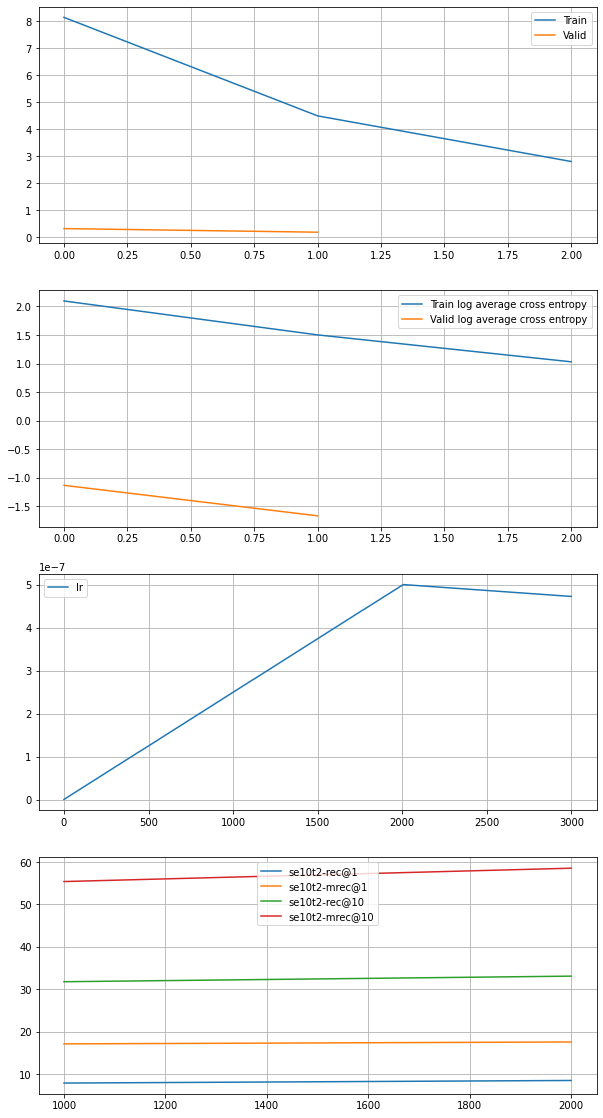

  0%|          | 0/1000 [00:00<?, ?it/s]

1
bright.a 1 During the siege , George Robertson had appointed Shuja-ul-Mulk , who was a  bright  boy only 12 years old and the youngest surviving son of Aman-ul-Mulk , as the ruler of Chitral . {'inteligente': 4, 'brillante': 3, 'listo': 2} ['brillante', 'inteligente', 'genial', 'claro', 'vivo', 'fuerte', 'genio', 'madrugar', 'vivaracho', 'prometedor', 'lumbrera']
2
bright.a 2 The actual field is not much different than that of a 40mm , only it is smaller and quite a bit noticeably  brighter  , which is probably the main benefit . {'brillante': 3, 'claro': 2, 'mejor': 1} ['inteligente', 'madrugar', 'fuerte', 'brillante', 'genial', 'vivo', 'genio', 'vivaracho', 'lumbrera', 'claro', 'prometedor']
3
bright.a 3 The roses have grown out of control , wild and carefree , their  bright  blooming faces turned to bathe in the early autumn sun . {'brillante': 3, 'rebosante': 1, 'luminoso': 1, 'claro': 1} ['genial', 'inteligente', 'brillante', 'fuerte', 'vivo', 'claro', 'lumbrera', 'genio', 'madr

take.v 21 That 's not to say the process of actual negotiating is n't  taking  place . {'pasar': 1, 'no se da pie a la negociacion': 1, 'no se esta haciendo possible la negociacion': 1, 'llevar a cabo': 1, 'ocurrir': 1, 'no se da lugar a la negociacion': 1} ['gusto', 'atentado', 'comer', 'ataque', 'descansar', 'continuar', 'mostrar', 'tomar', 'toma', 'saltar', 'incluir', 'prender', 'determinar', 'eliminar', 'retirar', 'sacar', 'delito', 'tener', 'conquistar', 'visitar', 'formar', 'seguir', 'ingresos', 'atractivo', 'parte', 'entrada', 'pasar', 'comprender', 'asumir', 'pegar']
22
take.v 22 " Hugh Grant and Alan Rickman , as Edward and Col. Brandon respectively ,  took  the most chances and the various reviewers therefore either love or hate their performances . {'tomar': 2, 'tomar los riesgos': 1} ['gusto', 'dar', 'comer', 'molde', 'prender', 'descansar', 'llevar', 'obtener', 'estudiar', 'recibir', 'incluir', 'determinar', 'forma', 'ingresos', 'pegar', 'hacer', 'empezar', 'entregar', 'mo

tight.r 36 " It can be intimidating at first , because they wrap their arms pretty  tight  around you , and everything they latch onto is pretty much headed straight to their mouth , " Schmitz said . {'apretado': 4, 'fuerte': 2, 'ajustado': 1, 'duro': 1} ['duro', 'dificil', 'fuerte', 'cerrado', 'apretado', 'agarrado', 'machete', 'pinche', 'renido', 'tenso', 'amarrete', 'escaso', 'cenido', 'callado', 'mojigato', 'riguroso', 'ajustado', 'tirante', 'puritano', 'borracho', 'hermetico', 'mudo', 'estricto', 'estrecho', 'pichirre', 'restringido', 'reprimido', 'emborracharse']
37
tight.r 37 The incisions will feel  tight  for the first 24-48 hours . {'apretado': 2, 'justo': 1, 'apretar': 1, 'molesto': 1, 'tirante': 1, 'tenso': 1, 'cerrado': 1, 'estirado': 1, 'tieso': 1} ['fuerte', 'duro', 'cerrado', 'dificil', 'escaso', 'estricto', 'agarrado', 'puritano', 'amarrete', 'callado', 'tirante', 'tenso', 'reprimido', 'mudo', 'renido', 'mojigato', 'apretado', 'cenido', 'riguroso', 'hermetico', 'ajusta

cross.n 51 When Time magazine 's cover portrays millennium nuts as deranged , crazy Christians holding a  cross  as it did last month , boycott their magazine and the products it advertises . {'cruz': 4, 'cruce': 1} ['cruz', 'cruza', 'cross', 'cruce', 'convencional', 'verificar', 'mezcla', 'frustrar', 'atravesar', 'rayar', 'cruzar', 'contrariar', 'verificacion', 'cruzado', 'comprobacion', 'tachar', 'seccion', 'traicion', 'bizco', 'enfadado', 'remision', 'traicionar', 'cruzarse', 'persignarse', '¿cruzamos', 'enojarse', 'contrademanda', 'enfadarse', 'enojado', 'santiguarse']
52
cross.n 52 Four-Set in a  cross  , the points meeting in water surrounded by luminous crescents . {'cruz': 3, 'cruce': 2, 'interseccion': 1} ['mezcla', 'cross', 'cruce', 'cruz', 'cruza', 'convencional', 'verificar', 'traicion', 'remision', 'cruzado', 'cruzar', 'seccion', 'cruzarse', 'rayar', 'verificacion', 'atravesar', 'traicionar', 'cross-country', 'frustrar', 'contrariar', '¿cruzamos', 'comprobacion', 'bizco', 

finally.r 69  Finally  , it is outlined how a mesoscopic theory should be constructed for a particular scanning tunneling microscopy experiment in order to overcome the failure of a corresponding reactiondiffusion model to quantitatively reproduce the experiments . {'finalmente': 4, 'por fin': 1, 'al final': 1, 'en conclusion': 1, 'por ultimo': 1} ['definitivamente', 'finalmente']
70
finally.r 70  Finally  , the proposed disposal rule would apply to transfer agents registered with the Commission . {'finalmente': 4, 'ultimamente': 1, 'por fin': 1, 'en conclusion': 1} ['definitivamente', 'finalmente']
71
find.v 71 Up to sixty percent of the fatty acid content in the grasses on the plains contain omega-3 and are  found  in abundance in buffalo allowed to graze on the natural grasses . {'encontrar': 2, 'contener': 1, 'incluir': 1, 'se encuentra': 1, 'alojar': 1, 'localizar': 1, 'se localiza': 1} ['fundar', 'descubrir', 'fundador', 'encontrar', 'sentir', 'alcanzar', 'localizar', 'enterarse

fix.v 88 The long-term problem with Social Security after 2042 could be totally  fixed  by raising the cap on income to a level needed to generate sufficient income to enable the system to continue to pay 100 percent indefinitely . {'arreglar': 3, 'componer': 2, 'restaurar': 1, 'resolver': 1, 'rectificar': 1, 'enmendar': 1, 'solucionar': 1} ['chute', 'posicion', 'organizar', 'preparar', 'rigido', 'fijar', 'fijo', 'aprieto', 'platudo', 'escoger', 'emparejar', 'maquillarse', 'arreglar', 'sujetar', 'pichicata', 'petrificado', 'amanar', 'fijado']
89
fix.v 89 The only way to  fix  this is for linux to get enough market share to be able to make demands for hardware support. [ reply ] [ top ] [ Â » ] Releasing specs is the only answer. by The Nose Who Knows - Feb 26th 2001 04:29:40 &gt; The other reason why vendors do n't support linux &gt; most of the time for commidity hardware such as &gt; webcam is low returns on investments . {'arreglar': 4, 'componer': 1, 'constituir': 1, 'crear': 1, 's

neat.a 107 The Society for Academic Emergency Medicine is a  neat  little bunch of people who are dedicated to furthering the interests of academia and research in the youngest of the medical specialties . {'conciso': 1, 'bien organizado': 1, 'organizado': 1, 'ordenado': 1, 'bien ordenado': 1} ['puro', 'cuidado', 'solo', 'bueno', 'guay', 'ordenado', 'habil', 'prolijo', 'cuidadoso', 'ingenioso', 'pulcro', 'arreglado']
108
neat.a 108 A weblog by Tom Coates who thinks up  neat  stuff for Yahoo ! {'claro': 2, 'conciso': 1, 'padre': 1, 'interesante': 1, 'ingenioso': 1, 'cosas admirables': 1, 'cosas geniales': 1, 'simple': 1, 'ordenado': 1} ['cuidado', 'puro', 'solo', 'guay', 'bueno', 'ordenado', 'cuidadoso', 'habil', 'pulcro', 'prolijo', 'ingenioso', 'arreglado']
109
neat.a 109 But not as odd as the 35 others who bedded down with him each night in a  neat  row down the street on a carpet of cardboard boxes and multicoloured raffia beach mats . {'ordenado': 3, 'simple': 1, 'derecho': 1, 'lim

In [ ]:
results = dict()
with open("results.json", "r") as f:
    results = json.load(f)

NUM_EPOCH = 20
num_warmup_steps = 2000
NUM_BATCHES_PER_EPOCH = 1000
NUM_BAD_ITERS = 3
for num_layers in ["all", 1, 2, 4, 6, 12]:
    for lr in [1e-5, 5 * 1e-6, 1e-6, 5 * 1e-5, 2.5 * 1e-5, 5 * 1e-7]:
        for func_name, loss_function in fuctions_mapping.items():
            if str((num_layers, lr, func_name)) in results:
                continue
            model = XLMRobertaForMaskedLM.from_pretrained('xlm-roberta-base')
            if str(num_layers) != "all":
                for param in model.parameters():
                    param.requires_grad = False
                for layer in get_params(model, num_layers):
                    for param in layer:
                        param.requires_grad = True
            model = model.to('cuda')
            cl = Classifier(model)
            from torch.optim import AdamW
            num_training_steps = NUM_BATCHES_PER_EPOCH * NUM_EPOCH
            from transformers import get_linear_schedule_with_warmup
            optimizer = AdamW(cl.parameters(), lr=lr)
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
            metrics = train_model()
            results[str((num_layers, lr, func_name))] = metrics
            del optimizer
            del scheduler
            del cl
            del model
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            with open("results.json", "w") as f:
                json.dump(results, f)

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# del optimizer
# del scheduler
# del cl
# del model
# gc.collect()

In [ ]:
res, outs = solve(Args())

In [ ]:
res